## исходные данные

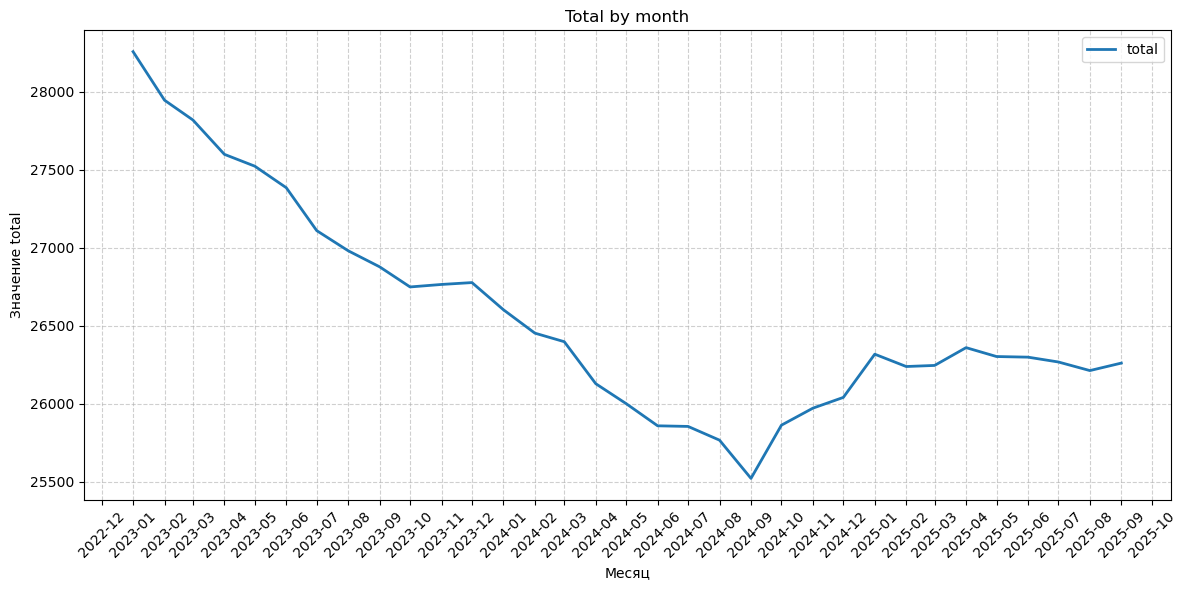

In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# готовим данные
df = pd.read_excel('forecast.xlsx')
df['date']  = pd.to_datetime(df['date'], format='%d.%m.%Y', errors='coerce')
df['total'] = pd.to_numeric(df['total'], errors='coerce')

#ГРАФИК
# 2) убираем битые строки и ставим равномерный месячный индекс
df = df.dropna(subset=['date', 'total']).set_index('date').asfreq('MS')
# 3) рисуем
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.index, df['total'], label='total', linewidth=2)
# ось X — каждый месяц
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
ax.set_title('Total by month')
ax.set_xlabel('Месяц'); ax.set_ylabel('Значение total')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


## проверка на стационарность Дики-Фуллер

In [9]:
def test_stationarity(series, title=''):
    print(f"Results of ADF Test on {title}:")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Non-stationary")
    else:
        print("stationary")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")
    print("\n")

test_stationarity(df['total'], 'Counts')

Results of ADF Test on Counts:
ADF Statistic: -1.827473740773018
p-value: 0.3669095516535523
Non-stationary
Critical Value (1%): -3.6790595944893187
Critical Value (5%): -2.9678817237279103
Critical Value (10%): -2.6231583472057074




## трейт и тест

In [13]:

train_size = int(len(df) * 0.75)

train = df.iloc[:train_size]   # первые 80% строк
test  = df.iloc[train_size:]   # последние 20% строк

print("Размер train:", train.shape)
print("Размер test :", test.shape)


Размер train: (24, 3)
Размер test : (9, 3)


## дифференциирование

In [15]:
# первое дифференцирование
train_diff1 = train["total"].diff().dropna()

# проверка снова
print("ADF p-value после 1 diff:", adfuller(train_diff1)[1])
test_stationarity(train_diff1, "Train after 1st diff")

ADF p-value после 1 diff: 0.002799243129112163
Results of ADF Test on Train after 1st diff:
ADF Statistic: -3.8107480328280947
p-value: 0.002799243129112163
stationary
Critical Value (1%): -3.769732625845229
Critical Value (5%): -3.005425537190083
Critical Value (10%): -2.6425009917355373




## модель ARIMA (подбор)

In [ ]:
p = 2
d = 1
q = 2

model = ARIMA(train["total"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

'''
Log Likelihood → «правдоподобие» модели. Чем выше (ближе к нулю), тем лучше.
AIC, BIC, HQIC → информационные критерии (Akaike, Байеса, Ханнана-Куинна).
Их используют для сравнения нескольких моделей: чем меньше, тем лучше.
'''

#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["total"] - forecast) / test["total"])) * 100
print(f"MAPE: {mape:.2f}%")


#проверка MAE
y_true = test["total"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

#график
plt.figure(figsize=(12,6))
plt.plot(train.index, train["total"], label="Train", color="blue")
plt.plot(test.index, test["total"], label="Test", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")

plt.title("Train/Test vs Forecast (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Значение total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()и

### выгрузка результатов

In [259]:
forecast = pd.Series(forecast.values, index=test.index, name="forecast")
print (forecast)

date
2024-12-01    25954.609877
2025-01-01    26027.113632
2025-02-01    26116.117286
2025-03-01    26177.574989
2025-04-01    26200.435361
2025-05-01    26194.685258
2025-06-01    26176.866823
2025-07-01    26160.156434
2025-08-01    26150.732288
2025-09-01    26148.766336
Freq: MS, Name: forecast, dtype: float64


## модель ARIMA (без подбора)

### ACF (Autocorrelation Function) - q

<Figure size 800x400 with 0 Axes>

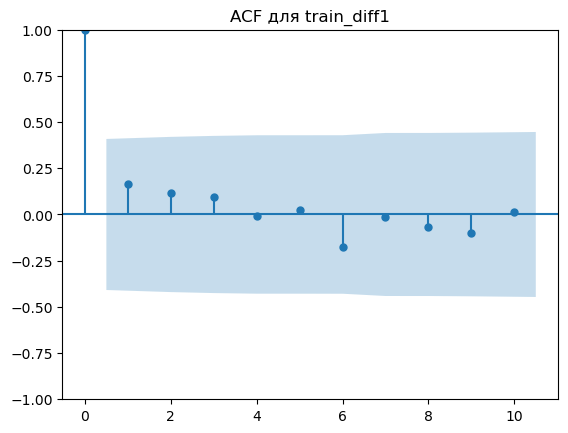

In [39]:
'''
q — это номер последнего “значимого” лага на графике ACF до резкого обрыва.
Если ACF имеет заметные столбики на лагах 1…q и дальше всё внутри синей зоны → MA(q).
Если значимых столбиков нет вообще → q = 0.

Лаг 0 = 1.0 — всегда игнорируем.
Лаги 1–10 — все внутри доверительных границ (синяя зона) → значимых пиков нет.
Для этого ряда после первой разности q = 0 (MA-компонента не требуется).

q = номер последнего подряд значимого лага, после которого ACF резко «обрывается» (остальные внутри зоны).
'''

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plot_acf(train_diff1, lags=10)
plt.title("ACF для train_diff1")
plt.show()



### PACF (Partial Autocorrelation Function) - p

<Figure size 800x400 with 0 Axes>

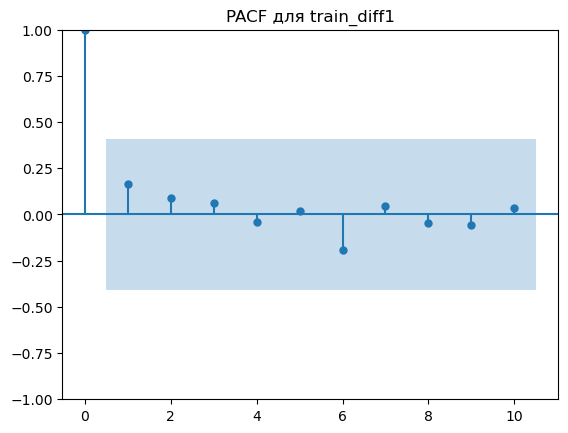

In [44]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plot_pacf(train_diff1, lags=10, method="ywm")  # "ywm" – более устойчивая оценка
plt.title("PACF для train_diff1")
plt.show()


### строим модель

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:                   24
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -150.874
Date:                Wed, 17 Sep 2025   AIC                            303.749
Time:                        23:18:50   BIC                            304.884
Sample:                    01-01-2023   HQIC                           304.034
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.915e+04    1.1e+04      2.648      0.008    7575.449    5.07e+04
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 8.28
Prob(Q):                              0.39   Pr

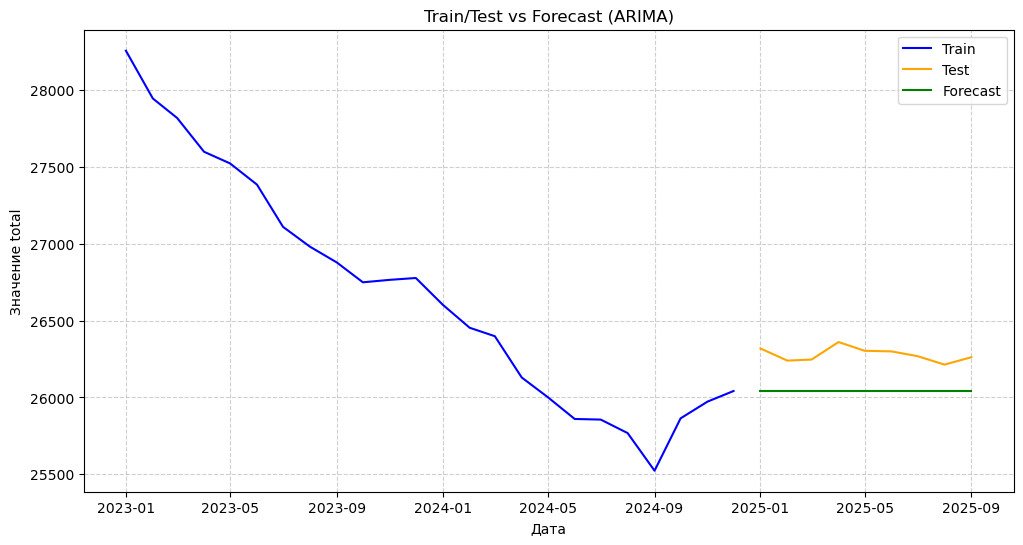

In [59]:
p = 0
d = 1
q = 0

model = ARIMA(train["total"], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

'''
Log Likelihood → «правдоподобие» модели. Чем выше (ближе к нулю), тем лучше.
AIC, BIC, HQIC → информационные критерии (Akaike, Байеса, Ханнана-Куинна).
Их используют для сравнения нескольких моделей: чем меньше, тем лучше.
'''

#проверка MAPE
forecast = model_fit.forecast(steps=len(test))
mape = np.mean(np.abs((test["total"] - forecast) / test["total"])) * 100
print(f"MAPE: {mape:.2f}%")


#проверка MAE
y_true = test["total"]        
y_pred = forecast            
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae:.2f}")

#график
plt.figure(figsize=(12,6))
plt.plot(train.index, train["total"], label="Train", color="blue")
plt.plot(test.index, test["total"], label="Test", color="orange")
plt.plot(test.index, forecast, label="Forecast", color="green")

plt.title("Train/Test vs Forecast (ARIMA)")
plt.xlabel("Дата")
plt.ylabel("Значение total")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## модель ARIMA (пакет optuna)

In [72]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [85]:
import numpy as np
import pandas as pd
import itertools
import optuna
from statsmodels.tsa.arima.model import ARIMA

# Подготовка данных
train_size = int(len(df) * 0.75)

train = df.iloc[:train_size]   # первые 75%
test  = df.iloc[train_size:]   # последние 25%

print("Размер train:", train.shape)
print("Размер test :", test.shape)

# добавляем для ARIMA
train_data = train['total']
test_data = test[['total']]

p = q = range(1, 10)
d = range(1, 4)
pdq = list(itertools.product(p, d, q))

def objective_arima(trial):
    order = trial.suggest_categorical('order', pdq)
    model = ARIMA(train_data, order=order)
    mdl = model.fit()
    predictions = mdl.forecast(len(test_data))
    predictions = pd.Series(predictions.values, index=test_data.index)
    residuals = test_data['total'] - predictions
    mse = np.sqrt(np.mean(residuals**2))
    accuracy = mse
    return accuracy

study = optuna.create_study(direction="minimize")
study.optimize(objective_arima, n_trials=20)

# после study.optimize(...)

# 1) Лучшие найденные параметры и ошибка
best_order = study.best_params['order']
best_rmse = study.best_value
print(f"Лучший порядок (p,d,q): {best_order}")
print(f"Минимальный RMSE: {best_rmse:.3f}")

# 2) Обучаем модель с лучшими параметрами и считаем метрики
best_model = ARIMA(train_data, order=best_order).fit()
best_forecast = best_model.forecast(len(test_data))
best_forecast = pd.Series(best_forecast.values, index=test_data.index)

y_true = test_data['total'].astype(float)
y_pred = best_forecast.astype(float)

mae  = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.2f}%")



[I 2025-09-17 23:39:04,316] A new study created in memory with name: no-name-3d517729-a113-4be1-bd84-4f160e8b8b09
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: U

Размер train: (24, 3)
Размер test : (9, 3)


C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 1) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 2) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 1, 3) which is of type tuple.
  warnings.warn(message)
C:\Users\eugen\anaconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persist

Лучший порядок (p,d,q): (2, 1, 2)
Минимальный RMSE: 81.804
MAE:  58.165
RMSE: 81.804
MAPE: 0.22%


C:\Users\eugen\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
